Models presented in notebook 5, with added mapping of emotions into a two dimensional plane, while still using discrete (classification) models, separate for each axis.

# Training models

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.svm import SVC
import pickle
from sklearn.mixture import GaussianMixture
import seaborn as sns
from reusable.emotion_mapping import SklearnTwoModelWrapper
MODELS_PATH = r'..\models\emotion_mapping_discrete'
PROCESSED_DATASET_PATH = r"..\dataset_processed"

## Load dataset

In [2]:
with open(rf"{PROCESSED_DATASET_PATH}\functional_features.pkl", "rb") as input_file:
    X = pickle.load(input_file)

In [3]:
Y = X['Emotion']
Y.unique()

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
      dtype=object)

In [4]:
X = X.drop(['Emotion','filepath'], axis=1)
X = StandardScaler().fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

In [6]:
np.array([x for x in y_train])

array(['Anger', 'Fear', 'Fear', ..., 'Fear', 'Happy', 'Surprise'],
      dtype='<U8')

## SVM

In [7]:
svm_model= SVC(random_state=42)
param_grid = {'C': [0.1, 1, 10,100], 'gamma': [1, 0.1, 0.01, 0.001,'auto'], 'kernel': ['linear', 'rbf']}
grid = RandomizedSearchCV(svm_model, param_grid, refit=True,verbose=1,cv=3,n_iter=10,random_state=42)
grid = SklearnTwoModelWrapper(grid).discrete()

grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[{'kernel': 'rbf', 'gamma': 'auto', 'C': 1}, {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}]


In [11]:
with open(rf"{MODELS_PATH}\svm_model.pkl", "wb") as output_file:
    pickle.dump(grid, output_file)

In [8]:
y_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7398541919805589


## Random Forest

In [17]:
rdf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6,8],
}
grid = GridSearchCV(rdf, param_grid, refit=True, verbose=1,cv=3)
grid = SklearnTwoModelWrapper(grid).discrete()
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [18]:
with open(rf"{MODELS_PATH}\rdf_model.pkl", "wb") as output_file:
    pickle.dump(grid, output_file)

In [19]:
y_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.670595382746051


## Ensemble method

In [18]:
rbm1_params = {
    'rbm1__n_components': [50, 100, 150,200],
    'rbm1__learning_rate': [0.01, 0.05, 0.1],
    'rbm1__n_iter': [10, 20, 30,50],
    'rbm1__batch_size': [32, 64, 128]
}
rbm2_params = {
    'rbm2__n_components': [50, 100, 150,200],
    'rbm2__learning_rate': [0.01, 0.05, 0.1],
    'rbm2__n_iter': [10, 20, 30,50],
    'rbm2__batch_size': [32, 64, 128]
}
svm_model = SVC(random_state=101)
svm_params = {'svm__C': [0.1, 1, 10,100], 'svm__gamma': [1, 0.1, 0.01, 0.001], 'svm__kernel': ['linear','rbf']}

rbm1= BernoulliRBM(random_state=42)
rbm2= BernoulliRBM(random_state=42)

grid= RandomizedSearchCV(Pipeline(steps=[('rbm1', rbm1),('rbm2',rbm2),('svm', svm_model)]), [rbm1_params,rbm2_params,svm_params], n_iter=1 ,cv=3,verbose=20,refit=True)
grid = SklearnTwoModelWrapper(grid).discrete()

grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [10]:
with open(rf"{MODELS_PATH}\ensemble_model_svm.pkl", "wb") as output_file:
    pickle.dump(grid, output_file)

In [11]:
y_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.31470230862697446


## MLP classifier

In [6]:
mlp_classifier = MLPClassifier(random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50),(50,50,50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.01,0.05, 0.1],
    'max_iter': [ 300,500]
}

grid= RandomizedSearchCV(mlp_classifier, param_distributions=param_grid, n_iter=15, cv=3, verbose=1, random_state=42,refit=True)
grid = SklearnTwoModelWrapper(grid).discrete()


grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'solver': 'adam', 'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'logistic'}


In [7]:
with open(rf"{MODELS_PATH}s\mlp_model.pkl", "wb") as output_file:
    pickle.dump(grid, output_file)

In [8]:
y_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7342648845686512


# Summary

In [35]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import pandas as pd

In [10]:
models = {}
with open(rf"{MODELS_PATH}\svm_model.pkl", "rb") as input_file:
    models['SVM'] = pickle.load(input_file)
with open(rf"{MODELS_PATH}\rdf_model.pkl", "rb") as input_file:
    models['RDF'] = pickle.load(input_file)
with open(rf"{MODELS_PATH}\ensemble_model_svm.pkl", "rb") as input_file:
    models['ensemble'] = pickle.load(input_file)
with open(rf"{MODELS_PATH}\mlp_model.pkl", "rb") as input_file:
    models['MLP'] = pickle.load(input_file)

In [57]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return_dict =  {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted',zero_division=0),
    }
    # if isinstance(model, dict):
    #     return_dict['ROC AUC'] = roc_auc_score(y_test, gmm_predict_proba(X_test, model), multi_class='ovr')
    # else:
    #     return_dict['ROC AUC'] = roc_auc_score(y_test, model.decision_function(X_test), multi_class='ovr')
    return return_dict

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [58]:
results_df = pd.DataFrame()
for model_name, model in models.items():
    result = evaluate(model, X_test,y_test)
    df = pd.DataFrame(result, index=[model_name])
    results_df = pd.concat([results_df, df])
print(results_df)

          Accuracy  F1 Score    Recall  Precision
SVM       0.773755  0.774358  0.773755   0.775411
XGB       0.789550  0.787020  0.789550   0.786842
RDF       0.670595  0.659417  0.670595   0.697386
ensemble  0.314702  0.180758  0.314702   0.174875
MLP       0.734265  0.734455  0.734265   0.735611
GMM       0.636574  0.634620  0.636574   0.648135


Confusion matrix for best performing model: XGBoost

In [71]:
y_pred = xgb_model.predict(X_test)
y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

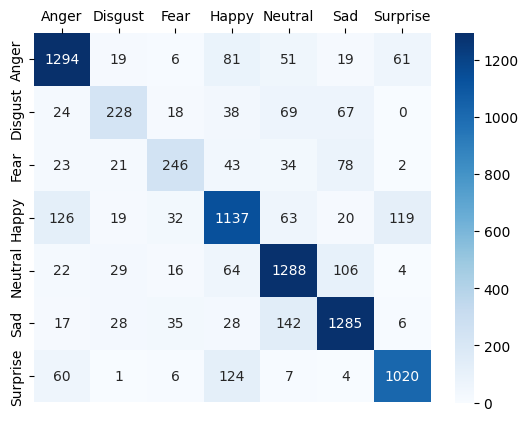

In [72]:
axs = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
axs.xaxis.set_ticks_position('top')

In [64]:
for class_label in le.classes_:
    print(f"Class {class_label}: Accuracy = {accuracy_score(y_true_labels[y_true_labels == class_label], y_pred_labels[y_true_labels == class_label])}")

Class Anger: Accuracy = 0.8451992161985631
Class Disgust: Accuracy = 0.5135135135135135
Class Fear: Accuracy = 0.5503355704697986
Class Happy: Accuracy = 0.75
Class Neutral: Accuracy = 0.842380640941792
Class Sad: Accuracy = 0.8338741077222582
Class Surprise: Accuracy = 0.8346972176759411
